In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import sph_harm
import torch

In [81]:
from dataclasses import dataclass
import torch.nn as nn

@dataclass
class HarmonicSpheres:
    weights: list[int]
    spheres: torch.Tensor
    weights: torch.Tensor

    def __init__(self, npoints=100):
        phi = np.linspace(0, np.pi, npoints)
        theta = np.linspace(0, 2*np.pi, npoints)
        phi, theta = np.meshgrid(phi, theta)
        self.x = np.sin(phi) * np.cos(theta)
        self.y = np.sin(phi) * np.sin(theta)
        self.z = np.cos(phi)

        self.weights = torch.rand((3, 9))

        self.spheres = torch.empty((9, npoints, npoints))

        harmonic_cf = [[0, 0], [1, 1], [0, 1], [-1, 1], [2, 2], [1, 2], [0,2], [-1, 2], [-2, 2]]
        for i, [m, l] in enumerate(harmonic_cf):
            self.spheres[i, :, :] = torch.tensor(sph_harm(m, l, theta, phi).real)

    def get_total(self):
        weights = self.weights
        npoints = self.spheres.shape[1]

        res = torch.ones((npoints, npoints, 4))
        res[:, :, :3] = (weights @ self.spheres.reshape((9, npoints*npoints))).T.reshape(npoints, npoints, 3)
        res = res.clamp(min=0, max=1)
        return res

    def get_cartesian(self):
        return self.x, self.y, self.z

In [82]:
# input: point on the sphere (theta, phi)
# output: color (rgba)

import torch.nn as nn

class SphereNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spheres = HarmonicSpheres()
        self.weights = nn.Parameter(self.spheres.weights, requires_grad=True)
        self.npoints = self.spheres.spheres.shape[1]

    def forward(self):
        spheres = self.spheres.spheres
        res = torch.ones((self.npoints, self.npoints, 4))
        res[:, :, :3] = (self.weights @ spheres.view((9, self.npoints*self.npoints))).T.view(self.npoints, self.npoints, 3)
        
        res = res.clamp(min=0, max=1)
        return res

In [146]:
import torch.optim as optim

spheres = HarmonicSpheres(100)
spheres.weights[0, :] = torch.tensor([1, 0, 1, 0, 0, 0, 0, 0, 0])
spheres.weights[1, :] = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0])
spheres.weights[2, :] = torch.tensor([0, 0, 1, 0, 0, 0, 1, 0, 0])

target = spheres.get_total()

model = SphereNet()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
epochs = 3000

for epoch in range(epochs):
    optimizer.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss.item())


0.07231757044792175
0.01011838112026453
0.0051738424226641655
0.0028381801676005125
0.0012486644554883242
0.0005222813342697918
0.0002662100887391716
0.00017096126975957304
0.00012749811867251992
0.00010262278374284506
8.581669681007043e-05
7.343701145146042e-05
6.393552030203864e-05
5.645563578582369e-05
5.043550845584832e-05
4.554683982860297e-05
4.155802889727056e-05
3.828814078588039e-05
3.558655225788243e-05
3.333593485876918e-05
3.14451681333594e-05
2.984456114063505e-05
2.847722680598963e-05
2.7296555344946682e-05
2.627000503707677e-05
2.537178988859523e-05
2.458049129927531e-05
2.387852146057412e-05
2.325125751667656e-05
2.2686601369059645e-05


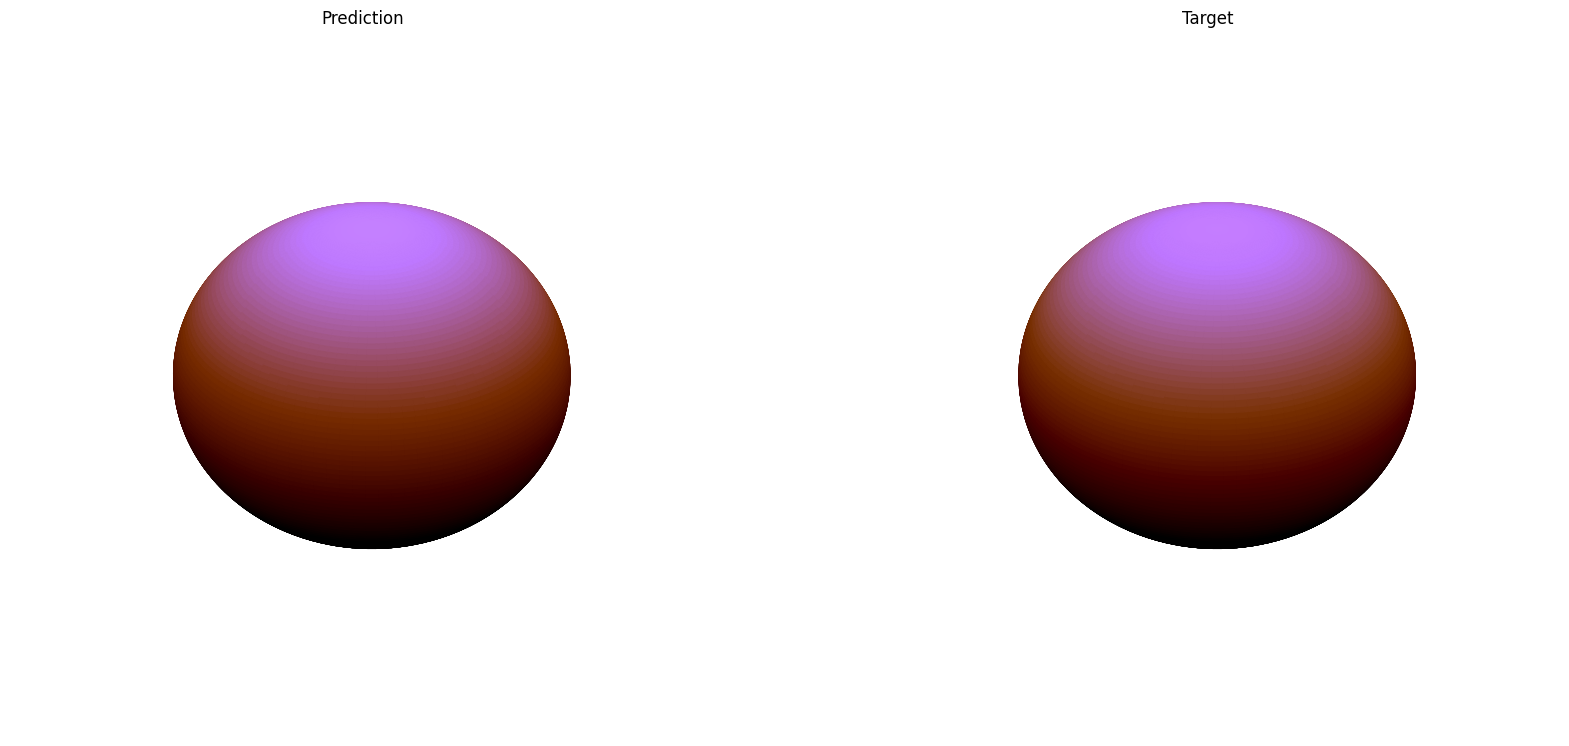

In [142]:
spheres = HarmonicSpheres(100)

predcolors = model.spheres.get_total().numpy()
targcolors = target.numpy()
x,y,z = spheres.get_cartesian()


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

# Equal harmonics, different orientation

This problem could be solved by calculating rotation-invariant properties of every plenoxel after the initial training phase. (Basically 'resetting' their orientation).

The following part is a bit messy, but I hope you get the point. In the end, I compare the frequency domains of the sampled colors of similar and dissimilar plenoxels. Using this, we can compare plenoxels with different orientations!

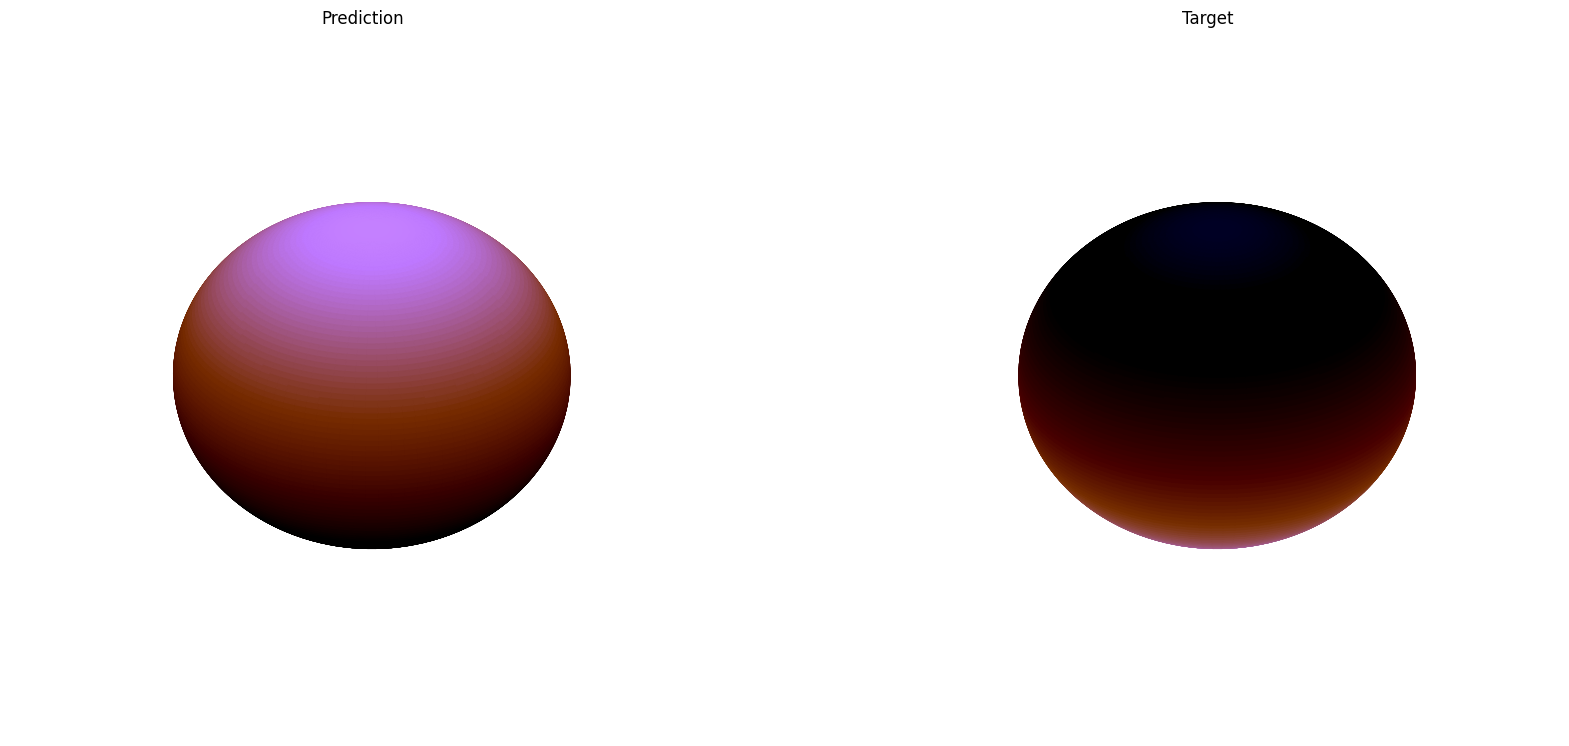

In [147]:
# rotating a sphere

Ry = lambda theta : np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0 , np.cos(theta)],
])
Rx = lambda theta : np.array([
    [1, 0, 0],
    [0, np.cos(theta), -np.sin(theta)],
    [0, np.sin(theta), np.cos(theta)],
])

#original_coords = np.array([x,y,z]).reshape(3, 100*100)
target = spheres.get_total()
target = torch.flip(target.view(100*100, 4), dims=[0]).view(100,100,4)
targcolors = target.numpy()
# Goal; get the new colors in the basis orientation

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

In [148]:
# Can we learn rcoords?
model = SphereNet()

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
epochs = 3000

for epoch in range(epochs):
    optimizer.zero_grad()

    out = model()
    loss = loss_fn(out, target)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(loss.item())

0.17206387221813202
0.029467012733221054
0.01927792839705944
0.01673293672502041
0.015654146671295166
0.01508280448615551
0.014100152999162674
0.006208349019289017
0.002285453723743558
0.0013285153545439243
0.0008417338249273598
0.00051929522305727
0.00029967608861625195
0.00016156368656083941
8.649528172099963e-05
5.0918341003125533e-05
3.5013221349800006e-05
2.7583229893934913e-05
2.3684706320636906e-05
2.1338741134968586e-05
1.9750583305722103e-05
1.8583845303510316e-05
1.7680455130175687e-05
1.695716127869673e-05
1.636392880755011e-05
1.5867644833633676e-05
1.544488623039797e-05
1.5078121577971615e-05
1.4754265976080205e-05
1.4464319974649698e-05


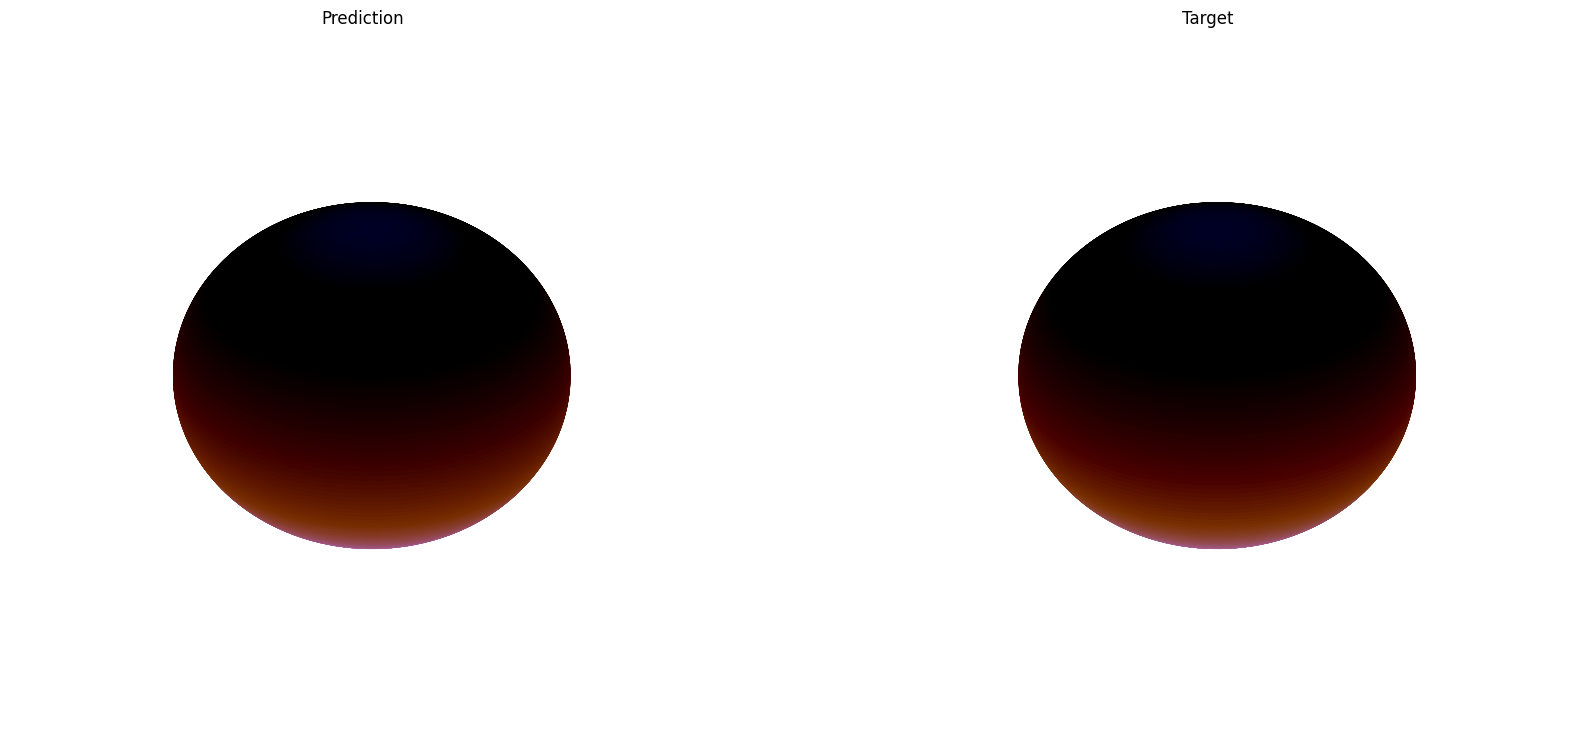

tensor([[ 1.0000,  0.1710, -0.9990,  0.1710, -0.1340,  0.5460,  0.0000,  0.5460,
          0.1340],
        [ 0.2490,  0.7760, -0.7070,  0.7880, -0.0130,  0.7070,  0.1320,  0.7170,
          0.0120],
        [ 0.0050,  0.6250, -0.9980,  0.6300,  0.0470,  0.4170,  0.9970,  0.4200,
         -0.0420]])
tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0.]])


In [153]:
predcolors = model.spheres.get_total().numpy()
targcolors = target.numpy()
x,y,z = spheres.get_cartesian()


# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(121, projection='3d')
ax.set_title("Prediction")
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=predcolors, shade=False)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Target")
ax2.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=targcolors, shade=False)
# Turn off the axis planes
ax.set_axis_off()
ax2.set_axis_off()
plt.show()

print((model.spheres.weights *1000).round()/1000)
print(spheres.weights)

In [214]:
# The following spherical harmonic frequencies are similar,
# but have different weights.
# tensor([[ 1.0000,  0.1710, -0.9990,  0.1710, -0.1340,  0.5460,  0.0000,  0.5460,0.1340],
#         [ 0.2490,  0.7760, -0.7070,  0.7880, -0.0130,  0.7070,  0.1320,  0.7170, 0.0120],
#         [ 0.0050,  0.6250, -0.9980,  0.6300,  0.0470,  0.4170,  0.9970,  0.4200,-0.0420]])
# tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
#         [0., 0., 1., 0., 0., 0., 1., 0., 0.]])

# Note that these two spheres have the same frequency domain.
# How can we convert these to the same? -> Fourier analysis on the colors?
predcol = model.spheres.get_total().view(100*100, 4)[:10000, :3]
targcol = spheres.get_total().view(100*100, 4)[:10000, :3]
predfft = torch.fft.fft(predcol, dim=1)
targfft = torch.fft.fft(targcol, dim=1)

othersphere = HarmonicSpheres()
otherfft = torch.fft.fft(othersphere.get_total().view(100*100, 4)[:10000, :3], dim = 1)

# plt.plot(predcol)
# plt.plot(targcol)

diff = abs((predfft-targfft).mean(dim=0)).sum()
diff2 = abs((predfft-otherfft).mean(dim=0)).sum()
print(f"Similar spheres: {diff}")
print(f"Dissimilar spheres: {diff2}")

Similar spheres: 0.000975277740508318
Dissimilar spheres: 0.4348866939544678
